# Project 4 | Wrangle and Analyze Data

## Table of Contents
- [Introduction](#intro)
- [Project Details](#details)
- [Data Wrangling Process](#wrangle)
    - [1. Gathering Data](#gather)
    - [2. Assessing Data](#assess)
    - [3. Cleaning Data](#clean)
- [Storing Data](#store)
- [Analyzing and Visualizing Data](#visual)
- [References](#ref)

<a id='intro'></a>
## Introduction

In this project, I will practice going through the entire data wrangling process (gather - assess - clean) and analyzing the tweet archive of Twitter user @dog_rates, which is also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. The aim of this project is to wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations.

<a id='details'></a>
## Project Details
The tasks that I will be practicing in this project are as follows:

1. Data wrangling, which consists of:
    - Gathering data 
    - Assessing data
    - Cleaning data


2. Storing, analyzing, and visualizing my wrangled data.


3. Reporting on 1) my data wrangling efforts and 2) my data analyses and visualizations


#### Key Points:
Key points that I will keep in mind when data wrangling for this project:

- I only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
- Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate my skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
- Cleaning includes merging individual pieces of data according to the rules of tidy data.
- The fact that the rating numerators are greater than the denominators does not need to be cleaned. This unique rating system is a big part of the popularity of WeRateDogs.
- I do not need to gather the tweets beyond August 1st, 2017. I can, but I won't be able to gather the image predictions for these tweets since I don't have access to the algorithm used.

<a id='wrangle'></a>
## Data Wrangling Process:

<a id='gather'></a>
## Step 1 | Gathering Data

This is the first step in the data wrangling process. For this project, I will gather each of the following pieces of data:

- WeRateDogs Twitter archive. This file has been giving to me, I will deal with it as a file on hand. I simply downloaded this file manually by clicking the link (twitter_archive_enhanced.csv) in my Udacity classroom.


- Tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and I will download it programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv


- Each tweet's retweet count and favorite ("like") count to enhance my analysis. Using the tweet IDs in the WeRateDogs Twitter archive, I will query Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data will be written to its own line. Then I will read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count.

In [1]:
# import the required libraries
import pandas as pd
import numpy as np

import requests as req
import json

import tweepy
from tweepy import OAuthHandler
from timeit import default_timer as timer

from bs4 import BeautifulSoup as bs

import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')

C:\Users\ftoom\anaconda3\envs\DAND\lib\site-packages\ipykernel\parentpoller.py:113: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  warnings.warn("""Parent poll failed.  If the frontend dies,


In [2]:
%config InlineBackend.figure_format = 'retina'

### 1.1. File on Hand (WeRateDogs Twitter Archive)

In [3]:
# read the csv file on hand into a pandas dataframe 
df_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### 1.2. File Downloaded Programmatically (Tweet Image Predictions)

In [4]:
# download Tweet Image Predictions file from the internet programmatically
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = req.get(url)

# check the request status 
response

<Response [200]>

In [5]:
# save the downloaded file 
with open (url.split('/')[-1] , mode = 'wb') as file:
    file.write(response.content)

# read the downloaded file into a pandas dataframe
df_predict = pd.read_csv('image-predictions.tsv' , sep = '\t')
df_predict.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### 1.3. JSON Data Queried using Twitter API (tweet ID, retweet count, favorite count)

In [6]:
consumer_key = 'hidden'
consumer_secret = 'hidden'
access_token = 'hidden'
access_secret = 'hidden'

# create an OAuthHandler instance with the consumer key and secret
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# get a wrapper for the API as provided by Twitter
api = tweepy.API(auth , wait_on_rate_limit = True , wait_on_rate_limit_notify = True)

In [7]:
# a list to store the ids of tweets that will fail to be retrieved
failed_ids_list = []
# a counter variable to keep track of the number of retrieved tweets
counter = 0

# to measure the start of the execution time
start = timer()

# open a destination file where the data retrieved using twitter api will be stored
with open('json_data.txt', 'w') as file:
    # querying each tweet ID in tweets archive dataframe
    for tweet_id in df_archive['tweet_id'].values:
        counter += 1       
        try:
            # fetch a tweet with a specific id and store it as a json object in the variable tweet
            tweet = api.get_status(tweet_id , tweet_mode = 'extended')._json
            # write the data object to the outfile
            json.dump(tweet , file)
            # write a new line after each json data
            file.write('\n')
        except tweepy.TweepError as te:
            # add the ids of tweet which failed to be retreived in the list
            failed_ids_list.append(tweet_id)
            print("{}: {} - fail ({})".format(counter , tweet_id , te))

# to measure the end of the execution time
end = timer()
  
# get the execution time in seconds
print("\nExecution time: {}".format(end - start))

20: 888202515573088257 - fail ([{'code': 144, 'message': 'No status found with that ID.'}])
96: 873697596434513921 - fail ([{'code': 144, 'message': 'No status found with that ID.'}])
102: 872668790621863937 - fail ([{'code': 144, 'message': 'No status found with that ID.'}])
105: 872261713294495745 - fail ([{'code': 144, 'message': 'No status found with that ID.'}])
119: 869988702071779329 - fail ([{'code': 144, 'message': 'No status found with that ID.'}])
133: 866816280283807744 - fail ([{'code': 144, 'message': 'No status found with that ID.'}])
156: 861769973181624320 - fail ([{'code': 144, 'message': 'No status found with that ID.'}])
183: 856602993587888130 - fail ([{'code': 144, 'message': 'No status found with that ID.'}])
212: 851953902622658560 - fail ([{'code': 144, 'message': 'No status found with that ID.'}])
248: 845459076796616705 - fail ([{'code': 144, 'message': 'No status found with that ID.'}])
254: 844704788403113984 - fail ([{'code': 144, 'message': 'No status fou

Rate limit reached. Sleeping for: 194


933: 754011816964026368 - fail ([{'code': 144, 'message': 'No status found with that ID.'}])
1727: 680055455951884288 - fail ([{'code': 144, 'message': 'No status found with that ID.'}])


Rate limit reached. Sleeping for: 22



Execution time: 2340.8170663


In [8]:
# get the number of tweet ids which failed to be retreived using the api 
len(failed_ids_list)

25

There are 25 tweets that were un-retrievable, this could be due to the deletion of these tweets by the twitter account user.

In [9]:
# read tweet_json.txt file line by line and store each json object in a list   
tweets_list = []
for line in open('json_data.txt', 'r'):
    tweets_list.append (json.loads(line + '\n'))

# display the contnet of the first json object in tweets_list
tweets_list[0]

{'created_at': 'Tue Aug 01 16:23:56 +0000 2017',
 'id': 892420643555336193,
 'id_str': '892420643555336193',
 'full_text': "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
 'truncated': False,
 'display_text_range': [0, 85],
 'entities': {'hashtags': [],
  'symbols': [],
  'user_mentions': [],
  'urls': [],
  'media': [{'id': 892420639486877696,
    'id_str': '892420639486877696',
    'indices': [86, 109],
    'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg',
    'url': 'https://t.co/MgUWQ76dJU',
    'display_url': 'pic.twitter.com/MgUWQ76dJU',
    'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1',
    'type': 'photo',
    'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
     'medium': {'w': 540, 'h': 528, 'resize': 'fit'},
     'small': {'w': 540, 'h': 528, 'resize': 'fit'},
     'large': {'w': 

In [10]:
# create a list of dictionaries with only the data we need from the list of json objects 
df_list = []  
for tweet in tweets_list:
    df_list.append({'tweet_id' : tweet['id'],
                    'retweet_count': tweet['retweet_count'],
                    'favorite_count' : tweet['favorite_count']
                  })
    
# display the contnet of the first json obejct in df_list
df_list[0]

{'tweet_id': 892420643555336193,
 'retweet_count': 7577,
 'favorite_count': 35812}

In [11]:
# create a pandas DataFrame using the list of dictionaries
df_json = pd.DataFrame(df_list, columns = ['tweet_id' , 'retweet_count' , 'favorite_count'])
df_json.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7577,35812
1,892177421306343426,5617,30916
2,891815181378084864,3718,23257
3,891689557279858688,7757,39077
4,891327558926688256,8354,37325


<a id='assess'></a>
## Step 2 | Assessing Data

The second step in the data wrangling process is **assessing** our data. When assessing, we are inspecting our dataset for two things:
- Data quality issues (content issues) 
- Tidiness issues (structural issues)

In this project, I will assess the gathered data visually and programmatically for quality and tidiness issues. 

### 2.1. Assessing `Twitter Archive` Table

In [12]:
# set the maximum width of each single field to display full dataframe information
pd.set_option('display.max_colwidth', -1)

<ipython-input-12-6e76c0835291>:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [13]:
# display the contetnt of twitter archive dataframe from visual assessment
df_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None


In [14]:
# check the dataframe for incorrect datatypes, missing rows , ambiguous column names 
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [15]:
# check the number of records which are retweets
sum(df_archive['text'].str.startswith('RT '))

183

In [16]:
# store the tweet ids of the retweets in a list to use it later in checking the other dataframes 
retweets_ids = list(df_archive[df_archive['text'].str.startswith('RT ')]['tweet_id'])
len(retweets_ids)

183

In [17]:
# check the unique values in source column
df_archive['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [18]:
# check duplicated values
sum(df_archive['tweet_id'].duplicated()) , sum(df_archive['text'].duplicated()) , sum(df_archive['expanded_urls'].duplicated())

(0, 0, 137)

In [19]:
# check tweets with duplicated images
df_archive[(df_archive['expanded_urls'].notna())][df_archive.duplicated(['expanded_urls'], keep='last')]

<ipython-input-19-dfde00709e6e>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_archive[(df_archive['expanded_urls'].notna())][df_archive.duplicated(['expanded_urls'], keep='last')]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,"https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1",14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…",8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Terrance. He's being yelled at because he stapled the wrong stuff together. 11/10 hang in there Terrance https://t.co/i…,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397445533696/photo/1,11,10,Terrance,None,None,None,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Coco. At first I thought she was a cloud but clouds don't bork with such passion. 12/10 would hug softly https://t.c…,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,"https://twitter.com/dog_rates/status/866334964761202691/photo/1,https://twitter.com/dog_rates/status/866334964761202691/photo/1",12,10,Coco,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Sierra. She's one precious pupper. Absolute 12/10. Been in and out of ICU her whole life. Help Sierra below\n\nhttps:/…,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,"https://www.gofundme.com/help-my-baby-sierra-get-better,https://twitter.com/dog_rates/status/873213775632977920/photo/1,https://twitter.com/dog_rates/status/873213775632977920/photo/1",12,10,Sierra,None,None,pupper,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,763167063695355904,NaN,NaN,2016-08-10 00:16:21 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Eve. She's a raging alcoholic 8/10 (would b 11/10 but pupper alcoholism is a tragic issue that I can't condone) https:/…,6.732953e+17,4.196984e+09,2015-12-06 00:17:55 +0000,https://twitter.com/dog_rates/status/673295268553605120/photo/1,8,10,Eve,None,None,pupper,None
937,753298634498793472,NaN,NaN,2016-07-13 18:42:44 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Carly. She's actually 2 dogs fused together. Very innovative. Probably has superpowers. 12/10 for double dog https:/…,6.815232e+17,4.196984e+09,2015-12-28 17:12:42 +0000,https://twitter.com/dog_rates/status/681523177663676416/photo/1,12,10,Carly,None,None,None,None
1012,747242308580548608,NaN,NaN,2016-06-27 01:37:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This pupper killed this great white in an epic sea battle. Now wears it as a trophy. Such brave. Much fierce. 13/10 https://…,7.047611e+17,4.196984e+09,2016-03-01 20:11:59 +0000,"https://twitter.com/

In [20]:
# check the number of tweets with duplicated images which are retweets
sum(df_archive[(df_archive['expanded_urls'].notna())][df_archive.duplicated(['expanded_urls'], keep='last')]['text'].str.startswith('RT '))

<ipython-input-20-cad2b8d2ded8>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sum(df_archive[(df_archive['expanded_urls'].notna())][df_archive.duplicated(['expanded_urls'], keep='last')]['text'].str.startswith('RT '))


78

78 out of 79 of the records which has a duplicated expanded_urls are retweets.

In [21]:
# check the existance of tweets with no images
df_archive[df_archive['expanded_urls'].isna()].shape[0]

59

In [22]:
# check the records of the tweets with no images
df_archive[df_archive['expanded_urls'].isna()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@Jack_Septic_Eye I'd need a few more pics to polish a full analysis, but based on the good boy content above I'm leaning towards 12/10",NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Jenna_Marbles: @dog_rates Thanks for rating my cermets 14/10 wow I'm so proud I watered them so much,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@xianmcguire @Jenna_Marbles Kardashians wouldn't be famous if as a society we didn't place enormous value on what they do. The dogs are very deserving of their 14/10,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [23]:
# check the number of tweets with no images which are replies to other tweets
df_archive[(df_archive['expanded_urls'].isna()) & (df_archive['in_reply_to_user_id'].notna())].shape[0]

55

In [24]:
# check the records of tweets with no images which are not replies to other tweets
df_archive[(df_archive['expanded_urls'].isna()) & (df_archive['in_reply_to_user_id'].isna())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Jenna_Marbles: @dog_rates Thanks for rating my cermets 14/10 wow I'm so proud I watered them so much,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
375,828361771580813312,NaN,NaN,2017-02-05 21:56:51 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Twitter Web Client</a>",Beebop and Doobert should start a band 12/10 would listen,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
707,785515384317313025,NaN,NaN,2016-10-10 16:20:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Today, 10/10, should be National Dog Rates Day",NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
1445,696518437233913856,NaN,NaN,2016-02-08 02:18:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Oh my god 10/10 for every little hot dog pupper,NaN,NaN,NaN,NaN,10,10,None,None,None,pupper,None


Most of the reords of tweets with no images which are replies to other tweets.

In [25]:
# display descriptive statistics for the rating columns
df_archive[['rating_numerator' , 'rating_denominator']].describe()

,rating_numerator,rating_denominator
count,2356.000000,2356.000000
mean,13.126486,10.455433
std,45.876648,6.745237
min,0.000000,0.000000
25%,10.000000,10.000000
50%,11.000000,10.000000
75%,12.000000,10.000000
max,1776.000000,170.000000


In [26]:
# display the value counts for the rating numerator column
df_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7       55 
14      54 
5       37 
6       32 
3       19 
4       17 
1       9  
2       9  
420     2  
0       2  
15      2  
75      2  
80      1  
20      1  
24      1  
26      1  
44      1  
50      1  
60      1  
165     1  
84      1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
17      1  
27      1  
45      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

In [27]:
# display the value counts for the rating denominator column
df_archive['rating_denominator'].value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [28]:
# check the number of records with rating of scales different than 10
df_archive.query('rating_denominator != 10').shape[0]

23

In [29]:
# check the text of the records with rating of scales different than 10
df_archive.query('rating_denominator != 10')[['text' , 'rating_numerator' , 'rating_denominator']]

,text,rating_numerator,rating_denominator
313,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24,7
784,"RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",9,11
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165,150
1068,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",9,11
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204,170
1165,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,4,20
1202,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50,50


In [30]:
# check the exsitance of records of tweets with ratings containing decimal points
df_archive[df_archive['text'].str.contains('(\d+\.\d*\/\d+)')][['text' , 'rating_numerator' , 'rating_denominator']]

C:\Users\ftoom\anaconda3\envs\DAND\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,text,rating_numerator,rating_denominator
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",5,10
340,"RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",75,10
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,27,10
1689,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,5,10
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10


In [31]:
# check the exsitance of records of tweets containing multiple ratings
df_archive[df_archive['text'].str.contains('\d+\/10(\S*\D*\d+\/10)+')][['text' , 'rating_numerator' , 'rating_denominator']]

C:\Users\ftoom\anaconda3\envs\DAND\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,text,rating_numerator,rating_denominator
55,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,17,10
561,"RT @dog_rates: ""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",12,10
766,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",12,10
860,RT @dog_rates: Meet Eve. She's a raging alcoholic 8/10 (would b 11/10 but pupper alcoholism is a tragic issue that I can't condone) https:/…,8,10
1007,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ,10,10
1222,Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp https://t.co/Akzl5ynMmE,10,10
1359,This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10 https://t.co/8rc5I22bBf,9,10
1459,"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P",4,10
1465,Meet Oliviér. He takes killer selfies. Has a dog of his own. It leaps at random &amp; can't bark for shit. 10/10 &amp; 5/10 https://t.co/6NgsQJuSBJ,10,10
1508,When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM,5,10


In [32]:
# check the number of records with the text "none" in the name column
df_archive.query('name == "None"').shape[0]

745

In [33]:
# check the number of records with the text "none" in all the stages columns
df_archive.query('doggo == "None" and floofer == "None" and pupper == "None" and puppo == "None"').shape[0]

1976

In [34]:
# get sample records of tweets with the text "none" in all the stages columns for visual assessment
df_archive.query('doggo == "None" and floofer == "None" and pupper == "None" and puppo == "None"')\
                [['text' , 'doggo', 'floofer', 'pupper', 'puppo']].sample(10)

,text,doggo,floofer,pupper,puppo
808,This is Davey. He'll have your daughter home by 8. Just a stand up pup. 11/10 would introduce to mom https://t.co/E6bGWf9EOm,None,None,None,None
1194,This is Skittle. He's trying to communicate. 11/10 solid effort https://t.co/6WTfJvtKx6,None,None,None,None
1870,holy shit 12/10 https://t.co/p6O8X93bTQ,None,None,None,None
177,"Instead of the usual nightly dog rate, I'm sharing this story with you. Meeko is 13/10 and would like your help \n\nhttps://t.co/Mj4j6QoIJk https://t.co/JdNE5oqYEV",None,None,None,None
1439,These two pirates crashed their ship and don't know what to do now. Very irresponsible of them. Both 9/10 https://t.co/RJvUjgGH5z,None,None,None,None
476,RT @dog_rates: This is Larry. He has no self control. Tongue still nifty af tho 11/10 https://t.co/ghyT4Ubk1r,None,None,None,None
635,This is Dobby. I can't stop looking at her feet. 12/10 would absolutely snug https://t.co/LhzPWv6rTv,None,None,None,None
461,"Say hello to Eugene &amp; Patti Melt. No matter how dysfunctional they get, they will never top their owners. Both 12/10 would pet at same time https://t.co/jQUdvtdYMu",None,None,None,None
1409,This is Yukon. He pukes rainbows. 12/10 magical af https://t.co/n6wND1v7il,None,None,None,None
1567,This is Louis. He's a rollercoaster of emotions. Incalculably fluffy. 12/10 would pet firmly https://t.co/17RGvOZO9P,None,None,None,None


In [35]:
# get sample records of tweets with one of the dog stages for visual assessment
df_archive.query('doggo != "None" or floofer != "None" or pupper != "None" or puppo != "None"')\
                [['text' , 'doggo', 'floofer', 'pupper', 'puppo']].sample(10)

,text,doggo,floofer,pupper,puppo
1615,This is Hubertson. He's a Carmel Haberdashery. Enjoys long summer days on his boat. Very peaceful pupper. 10/10 https://t.co/vzCl35fKlZ,None,None,pupper,None
1012,RT @dog_rates: This pupper killed this great white in an epic sea battle. Now wears it as a trophy. Such brave. Much fierce. 13/10 https://…,None,None,pupper,None
1391,When it's Janet from accounting's birthday but you can't eat the cake cuz it's chocolate. 10/10 hang in there pupper https://t.co/Fbdr5orUrJ,None,None,pupper,None
1845,"This is Pepper. She's not fully comfortable riding her imaginary bike yet. 10/10 don't worry pupper, it gets easier https://t.co/40dj4eTsXG",None,None,pupper,None
1113,"Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",doggo,None,pupper,None
397,RT @dog_rates: Say hello to Pablo. He's one gorgeous puppo. A true 12/10. Click the link to see why Pablo requests your assistance\n\nhttps:/…,None,None,None,puppo
1039,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,doggo,None,None,None
924,This is one of the most inspirational stories I've ever come across. I have no words. 14/10 for both doggo and owner https://t.co/I5ld3eKD5k,doggo,None,None,None
1945,This is Raymond. He's absolutely terrified of floating tennis ball. 10/10 it'll be ok pupper https://t.co/QyH1CaY3SM,None,None,pupper,None
1732,Everybody look at this beautiful pupper 13/10 https://t.co/hyAC5Hq9GC,None,None,pupper,None


In [36]:
# check the number of records with no dog name and stage
df_archive.query('doggo == "None" and floofer == "None" and pupper == "None" and puppo == "None" and name == "None"').shape[0]

585

### 2.2. Assessing `Image Predictions` Table

In [37]:
# display the contetnt of image predictions dataframe from visual assessment
df_predict

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [38]:
# check the dataframe for incorrect datatypes, missing rows , ambiguous column names 
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [39]:
# check duplicated values
sum(df_predict['tweet_id'].duplicated()) , sum(df_predict['jpg_url'].duplicated())

(0, 66)

In [40]:
# check the records of tweets with duplicated images
df_predict[df_predict.duplicated(['jpg_url'], keep=False)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
85,667509364010450944,https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg,1,beagle,0.636169,True,Labrador_retriever,0.119256,True,golden_retriever,0.082549,True
224,670319130621435904,https://pbs.twimg.com/media/CU1zsMSUAAAS0qW.jpg,1,Irish_terrier,0.254856,True,briard,0.227716,True,soft-coated_wheaten_terrier,0.223263,True
241,670444955656130560,https://pbs.twimg.com/media/CU3mITUWIAAfyQS.jpg,1,English_springer,0.403698,True,Brittany_spaniel,0.347609,True,Welsh_springer_spaniel,0.137186,True
327,671896809300709376,https://pbs.twimg.com/media/CVMOlMiWwAA4Yxl.jpg,1,chow,0.243529,True,hamster,0.227150,False,Pomeranian,0.056057,True
382,673320132811366400,https://pbs.twimg.com/media/CVgdFjNWEAAxmbq.jpg,3,Samoyed,0.978833,True,Pomeranian,0.012763,True,Eskimo_dog,0.001853,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1970,868880397819494401,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
1992,873697596434513921,https://pbs.twimg.com/media/DA7iHL5U0AA1OQo.jpg,1,laptop,0.153718,False,French_bulldog,0.099984,True,printer,0.077130,False
2041,885311592912609280,https://pbs.twimg.com/media/C4bTH6nWMAAX_bJ.jpg,1,Labrador_retriever,0.908703,True,seat_belt,0.057091,False,pug,0.011933,True
2051,887473957103951883,https://pbs.twimg.com/media/DFDw2tyUQAAAFke.jpg,2,Pembroke,0.809197,True,Rhodesian_ridgeback,0.054950,True,beagle,0.038915,True


In [41]:
# display descriptive statistics for the numerical columns
df_predict[['img_num' , 'p1_conf','p2_conf' , 'p3_conf']].describe()

,img_num,p1_conf,p2_conf,p3_conf
count,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,1.203855,0.594548,1.345886e-01,6.032417e-02
std,0.561875,0.271174,1.006657e-01,5.090593e-02
min,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,1.000000,0.843855,1.955655e-01,9.180755e-02
max,4.000000,1.000000,4.880140e-01,2.734190e-01


In [42]:
# check the existance of retweets
sum(df_predict['tweet_id'].isin(retweets_ids))

82

### 2.3. Assessing `JSON Data` Table

In [43]:
# display the contetnt of json dataframe from visual assessment
df_json

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7577,35812
1,892177421306343426,5617,30916
2,891815181378084864,3718,23257
3,891689557279858688,7757,39077
4,891327558926688256,8354,37325
...,...,...,...
2326,666049248165822465,40,96
2327,666044226329800704,130,266
2328,666033412701032449,41,111
2329,666029285002620928,42,120


In [44]:
# check the dataframe for incorrect datatypes, missing rows , ambiguous column names 
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [45]:
# display descriptive statistics for the numerical columns
df_json[['retweet_count', 'favorite_count']].describe()

,retweet_count,favorite_count
count,2331.000000,2331.000000
mean,2663.229086,7475.833119
std,4503.843766,11608.558262
min,1.000000,0.000000
25%,539.500000,1301.000000
50%,1245.000000,3250.000000
75%,3095.500000,9153.000000
max,76550.000000,154279.000000


In [46]:
# check duplicated values
sum(df_json[['tweet_id']].duplicated())

0

In [47]:
# check the existance of retweets
sum(df_json['tweet_id'].isin(retweets_ids))

165

### Quality Issues:

##### `Twitter Archive` Table

1. Erroneous datatypes (timestamp , in_reply_to_status_id , in_reply_to_user_id , dog stages).
2. Unneeded columns (retweeted_status_id , retweeted_status_user_id , retweeted_status_timestamp).
3. Existence of records with retweets.
4. The data in source column contains html anchor tags which makes the information in it un-understandable.
5. Existence of tweets with no images (expanded_urls), and most of them are replies to other tweets.
6. Existence of tweets with duplicated images (expanded_urls), and it appears that most of them are retweets.
7. Erroneous extracted ratings:
     - some ratings are out of scales different than 10
     - some ratings contain decimal part
     - some extracted values don't represent ratings
     - some tweets contain multiple rating values
8. Nulls represented as the string (None) in name and dog stages columns.

##### `Image Predictions` Table

9. Inconsistence usage of capitalization in p1, p2, p3 columns & underscores and dashes between words.
10. Existence of tweets with duplicated images (jpg_url), these might be retweets. 
11. Existence of records with retweets.
12. Non-descriptive column names.

##### `JSON Data` Table

13. Existence of records with retweets.

### Tidiness Issues:

1. One variable in multiple columns for dog stages in `Twitter Archive` ('doggo', 'floofer', 'pupper', 'puppo').
2. Timestamp column in `Twitter Archive` contains two variables: date and time.
3. Image predictions columns and retweet and favorite counts should be part of `Twitter Archive` table.

<a id='clean'></a>
## Step 3 | Cleaning Data


Cleaning data is the third step in the data wrangling process. It is where we will fix the quality and tidiness issues that have been identified in the assessment step. In this section, I will clean each of the issues I documented earlier. 

The cleaning sequence that I will be following is: multiple **Define**, **Code**, and **Test** headers, one for each data quality and tidiness issue / or group of related data quality and tidiness issues. As for the cleaning approach, I will tackle the tidiness issues first, then clean up the quality issues.

The first thing to do before starting cleaning is making a copy of each piece of data, in which all the cleaning operations will be conducted on these copies. 

In [48]:
# making copies of the gathered datarames
df_archive_clean = df_archive.copy()
df_predict_clean = df_predict.copy()
df_json_clean = df_json.copy()

### 3.1 Tackling Tidiness Issues

#### 1. Timestamp column in `Twitter Archive` contains two variables: date and time

#### Define

- Split timestamp column into two columns (date and time) using str.split method.
- Drop timestamp column when done.

#### Code

In [49]:
# check the structure of values in timestamp column
df_archive_clean['timestamp'][0]

'2017-08-01 16:23:56 +0000'

In [50]:
# create a new dataframe that consist of the result of splitting timestamp column
splitted_columns = df_archive_clean['timestamp'].str.split(' ', n = 2, expand = True)
splitted_columns

,0,1,2
0,2017-08-01,16:23:56,+0000
1,2017-08-01,00:17:27,+0000
2,2017-07-31,00:18:03,+0000
3,2017-07-30,15:58:51,+0000
4,2017-07-29,16:00:24,+0000
...,...,...,...
2351,2015-11-16,00:24:50,+0000
2352,2015-11-16,00:04:52,+0000
2353,2015-11-15,23:21:54,+0000
2354,2015-11-15,23:05:30,+0000


In [51]:
# check the unique values in the third part of timestamp column
splitted_columns[2].unique()

array(['+0000'], dtype=object)

Since the third column resulted from split method has the value '+0000' for all the rows, there is no need it to add to our dataframe.

In [52]:
# add two columns for date and time in twitter archive dataframe
df_archive_clean['date'] = splitted_columns[0]
df_archive_clean['time'] = splitted_columns[1]

In [53]:
# drop timestamp column
df_archive_clean.drop('timestamp', axis = 1 , inplace = True)

#### Test

In [54]:
# confirm that timestamp column is gone
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   source                      2356 non-null   object 
 4   text                        2356 non-null   object 
 5   retweeted_status_id         181 non-null    float64
 6   retweeted_status_user_id    181 non-null    float64
 7   retweeted_status_timestamp  181 non-null    object 
 8   expanded_urls               2297 non-null   object 
 9   rating_numerator            2356 non-null   int64  
 10  rating_denominator          2356 non-null   int64  
 11  name                        2356 non-null   object 
 12  doggo                       2356 non-null   object 
 13  floofer                     2356 

In [55]:
# check the content of time and date columns
df_archive_clean[['date' , 'time']].sample(10)

,date,time
521,2016-12-17,00:38:52
777,2016-09-14,16:00:49
2186,2015-11-24,02:38:07
2116,2015-11-28,02:20:27
805,2016-09-03,16:52:02
1165,2016-04-21,02:25:47
1451,2016-02-06,02:22:53
507,2016-12-24,17:18:34
175,2017-04-28,16:08:49
2346,2015-11-16,01:01:59


#### 2. `Twitter Archive`: One variable in multiple columns for dog stages ('doggo', 'floofer', 'pupper', 'puppo')

#### Define

- Combine the four stages columns in a single column.
- Extract the dog stage from the combined column using str.extract and a regular expression.
- Drop the original stages columns.

#### Code

In [56]:
# combine the four stages columns in a single column
df_archive_clean['dog_stage'] = df_archive_clean['doggo'] + df_archive_clean['floofer'] + \
                                df_archive_clean['pupper'] + df_archive_clean['puppo']
# extract the dog stage from the combined column
df_archive_clean['dog_stage'] = df_archive_clean['dog_stage'].str.extract('(doggo|floofer|pupper|puppo)')
# drop the original stages columns
df_archive_clean.drop(['doggo' , 'floofer' , 'pupper' , 'puppo'] , axis = 1 , inplace = True)

#### Test

In [57]:
# confirm that stages columns are gone , and check the number of non-null values in the new stage column
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   source                      2356 non-null   object 
 4   text                        2356 non-null   object 
 5   retweeted_status_id         181 non-null    float64
 6   retweeted_status_user_id    181 non-null    float64
 7   retweeted_status_timestamp  181 non-null    object 
 8   expanded_urls               2297 non-null   object 
 9   rating_numerator            2356 non-null   int64  
 10  rating_denominator          2356 non-null   int64  
 11  name                        2356 non-null   object 
 12  date                        2356 non-null   object 
 13  time                        2356 

In [58]:
# check the unique values in the new stage column
df_archive_clean['dog_stage'].value_counts()

pupper     245
doggo      97 
puppo      29 
floofer    9  
Name: dog_stage, dtype: int64

#### 3. Image predictions columns and retweet and favorite counts should be part of `Twitter Archive` table.

#### Define
Merge `Image Predictions` and `json Data` tables with the `Twitter Archive` table, joining on *tweet_id*.

#### Code

In [59]:
# merge Image Prediction table with the Twitter Archive table
df_archive_clean = pd.merge(df_archive_clean, df_predict_clean , on=['tweet_id'], how='left')

# merge json Data table with the Twitter Archive table
df_archive_clean = pd.merge(df_archive_clean, df_json_clean , on=['tweet_id'], how='left')

#### Test

In [60]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   source                      2356 non-null   object 
 4   text                        2356 non-null   object 
 5   retweeted_status_id         181 non-null    float64
 6   retweeted_status_user_id    181 non-null    float64
 7   retweeted_status_timestamp  181 non-null    object 
 8   expanded_urls               2297 non-null   object 
 9   rating_numerator            2356 non-null   int64  
 10  rating_denominator          2356 non-null   int64  
 11  name                        2356 non-null   object 
 12  date                        2356 non-null   object 
 13  time                        2356 

### 3.2 Cleaning up Quality Issues

#### 1. Erroneous datatypes:  (in_reply_to_status_id , in_reply_to_user_id, date, dog_stage, retweet_count , favorite_count, img_num, p1_dog , p2_dog , p3_dog).

After merging json data table with twitter archive, the data type of the merged columns have changed, so I will clean up that along with the columns specified in the assessment step.

#### Define
Convert:
- dog_stage to categorical data type.
- date to dat data type. 
- in_reply_to_status_id, in_reply_to_user_id, retweet_count, favorite_count, img_num to integer data type.
- p1_dog , p2_dog , p3_dog to boolean data type.

#### Code

In [61]:
# convert to category
df_archive_clean['dog_stage'] = df_archive_clean['dog_stage'].astype('category')

In [62]:
# convert to datetime
df_archive_clean['date'] = pd.to_datetime(df_archive_clean['date'])

In [63]:
# convert to integer
df_archive_clean['in_reply_to_status_id'] = df_archive_clean['in_reply_to_status_id'].astype('Int64')
df_archive_clean['in_reply_to_user_id'] = df_archive_clean['in_reply_to_user_id'].astype('Int64')
df_archive_clean['retweet_count'] = df_archive_clean['retweet_count'].astype('Int64')
df_archive_clean['favorite_count'] = df_archive_clean['favorite_count'].astype('Int64')
df_archive_clean['img_num'] = df_archive_clean['img_num'].astype('Int64')

In [64]:
# convert to boolean
df_archive_clean['p1_dog'] = df_archive_clean['p1_dog'].astype(bool)
df_archive_clean['p2_dog'] = df_archive_clean['p2_dog'].astype(bool)
df_archive_clean['p3_dog'] = df_archive_clean['p3_dog'].astype(bool)

#### Test

In [65]:
# check the columns data types
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2356 non-null   int64         
 1   in_reply_to_status_id       78 non-null     Int64         
 2   in_reply_to_user_id         78 non-null     Int64         
 3   source                      2356 non-null   object        
 4   text                        2356 non-null   object        
 5   retweeted_status_id         181 non-null    float64       
 6   retweeted_status_user_id    181 non-null    float64       
 7   retweeted_status_timestamp  181 non-null    object        
 8   expanded_urls               2297 non-null   object        
 9   rating_numerator            2356 non-null   int64         
 10  rating_denominator          2356 non-null   int64         
 11  name                        2356 non-null   object      

#### 2. Existence of records with retweets.

#### Define

Drop the records in which the text starts with 'RT' from  twitter archive dataframe.

#### Code

In [66]:
# drop the retweets records from twitter archive dataframe
df_archive_clean.drop(df_archive_clean[df_archive_clean['text'].str.startswith('RT ')].index , inplace = True)

In [67]:
# drop the retweets records from images prediction dataframe
df_predict_clean.drop(df_predict_clean[df_predict_clean['tweet_id'].isin(retweets_ids)].index , inplace = True)

In [68]:
# drop the retweets records from json data dataframe
df_json_clean.drop(df_json_clean[df_json_clean['tweet_id'].isin(retweets_ids)].index , inplace = True)

#### Test

In [69]:
# confirm that retweets records are gone from twitter archive dataframe
df_archive_clean[df_archive_clean['text'].str.startswith('RT ')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count


In [70]:
# confirm that retweets records are gone from images prediction dataframe
sum(df_predict_clean['tweet_id'].isin(retweets_ids))

0

In [71]:
# confirm that retweets records are gone from json data dataframe
sum(df_json_clean['tweet_id'].isin(retweets_ids))

0

#### 3.  Unneeded columns (retweeted_status_id , retweeted_status_user_id , retweeted_status_timestamp).

After dropping the retweets records, the columns related to retweets have become useless and it need to be dropped too.

#### Define

Drop retweeted_status_id , retweeted_status_user_id , and retweeted_status_timestamp columns.

#### Code

In [72]:
# drop unneeded columns
df_archive_clean.drop(['retweeted_status_id' , 'retweeted_status_user_id' , 'retweeted_status_timestamp']\
                      , axis = 1 , inplace = True)

#### Test

In [73]:
# confirm that the columns related to the retweets are gone
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2173 entries, 0 to 2355
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tweet_id               2173 non-null   int64         
 1   in_reply_to_status_id  78 non-null     Int64         
 2   in_reply_to_user_id    78 non-null     Int64         
 3   source                 2173 non-null   object        
 4   text                   2173 non-null   object        
 5   expanded_urls          2115 non-null   object        
 6   rating_numerator       2173 non-null   int64         
 7   rating_denominator     2173 non-null   int64         
 8   name                   2173 non-null   object        
 9   date                   2173 non-null   datetime64[ns]
 10  time                   2173 non-null   object        
 11  dog_stage              344 non-null    category      
 12  jpg_url                1993 non-null   object        
 13  img

#### 4.  Existence of tweets with duplicated images (expanded_urls).

Previously in the assessment step, we found that 79 records have duplicated images in which 78 of them were retweets. This means that we are only left with one record with a duplicated image URL which must be removed.

#### Define
Drop the record with duplicated expanded_url.

#### Code

In [74]:
# check if the record with a duplicated image still exist
df_archive_clean[(df_archive_clean['expanded_urls'].notna())][df_archive_clean.duplicated(['expanded_urls'], keep='last')].shape[0]

<ipython-input-74-fe4398a15b58>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_archive_clean[(df_archive_clean['expanded_urls'].notna())][df_archive_clean.duplicated(['expanded_urls'], keep='last')].shape[0]


1

In [75]:
# check the content of that record
df_archive_clean[(df_archive_clean['expanded_urls'].notna())][df_archive_clean.duplicated(['expanded_urls'], keep = False)]

<ipython-input-75-fc9571150822>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_archive_clean[(df_archive_clean['expanded_urls'].notna())][df_archive_clean.duplicated(['expanded_urls'], keep = False)]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,date,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
657,791774931465953280,<NA>,<NA>,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Vine will be deeply missed. This was by far my favorite one. 14/10 https://t.co/roqIxCvEB3,https://vine.co/v/ea0OwvPTx9l,14,10,None,2016-10-27,...,NaN,True,NaN,NaN,True,NaN,NaN,True,22371,45492
2212,668587383441514497,<NA>,<NA>,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>",Never forget this vine. You will not stop watching for at least 15 minutes. This is the second coveted.. 13/10 https://t.co/roqIxCvEB3,https://vine.co/v/ea0OwvPTx9l,13,10,the,2015-11-23,...,NaN,True,NaN,NaN,True,NaN,NaN,True,1005,1577


In [76]:
# get the index of the record
index = df_archive_clean[(df_archive_clean['expanded_urls'].notna())][df_archive_clean.duplicated(['expanded_urls'], keep = 'last')].index
index

<ipython-input-76-3b6fcc688da6>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  index = df_archive_clean[(df_archive_clean['expanded_urls'].notna())][df_archive_clean.duplicated(['expanded_urls'], keep = 'last')].index


Int64Index([657], dtype='int64')

In [77]:
# drop the record
df_archive_clean.drop(index , inplace = True)

#### Test

In [78]:
# confirm that the record has been dropped, this should be false
index[0] in df_archive_clean.index

False

#### 5.  Existence of tweets with no images (expanded_urls).

#### Define
Drop the recods of tweets with null expanded_urls.

#### Code

In [79]:
# drop the records of tweets with null expanded_urls
df_archive_clean.drop(df_archive_clean[(df_archive_clean['expanded_urls'].isna())].index , inplace = True)

#### Test

In [80]:
# confirm that records of tweets with null expanded_urls are gone
df_archive_clean[(df_archive_clean['expanded_urls'].isna())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,date,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count


#### 6. The data in source column contains html anchor tags which makes the information in it un-understandable.

#### Define
Extract the text between html anchor tags using BeautifulSoup parser.

#### Code

In [81]:
# check the structure of the values in source column
df_archive_clean['source'].unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

In [82]:
# loop through each values in source column and extract the text between the html tag
for i in df_archive_clean.index:
    df_archive_clean['source'][i] = bs(df_archive_clean['source'][i]).a.contents[0].split('-')[0].strip()

<ipython-input-82-b3e8397c389d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_archive_clean['source'][i] = bs(df_archive_clean['source'][i]).a.contents[0].split('-')[0].strip()


#### Test

In [83]:
# check the unique extracted values 
df_archive_clean['source'].unique()

array(['Twitter for iPhone', 'Twitter Web Client', 'Vine', 'TweetDeck'],
      dtype=object)

In [84]:
df_archive_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,expanded_urls,rating_numerator,rating_denominator,name,date,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
1105,734912297295085568,<NA>,<NA>,Twitter for iPhone,This is Jax. He's a literal fluffball. Sneaky tongue slip. 10/10 would pet nonstop https://t.co/9MGouPwQmK,https://twitter.com/dog_rates/status/734912297295085568/photo/1,10,10,Jax,2016-05-24,...,0.847292,True,feather_boa,0.059379,False,Old_English_sheepdog,0.052758,True,516,2702
1330,705786532653883392,703255935813287936,4196983835,Twitter for iPhone,"Seriously, add us 🐶 11/10 for sad wet pupper https://t.co/xwPE9faVZR",https://twitter.com/dog_rates/status/705786532653883392/photo/1,11,10,None,2016-03-04,...,0.550294,False,Labrador_retriever,0.148496,True,golden_retriever,0.148482,True,508,1900
912,757596066325864448,<NA>,<NA>,Twitter for iPhone,Here's another picture without a dog in it. Idk why you guys keep sending these. 4/10 just because that's a neat rug https://t.co/mOmnL19Wsl,https://twitter.com/dog_rates/status/757596066325864448/photo/1,4,10,None,2016-07-25,...,0.845256,False,wallet,0.095718,False,wool,0.026072,False,1045,4309
1542,689599056876867584,<NA>,<NA>,Twitter for iPhone,Here we see 33 dogs posing for a picture. All get 11/10 for superb cooperation https://t.co/TRAri5iHzd,https://twitter.com/dog_rates/status/689599056876867584/photo/1,11,10,None,2016-01-20,...,0.426494,False,cocker_spaniel,0.073101,True,Chihuahua,0.070323,True,5404,11477
407,823699002998870016,<NA>,<NA>,Twitter for iPhone,This is Winston. The goggles make him a superhero. Protects the entire city from criminals unless they rub his belly really well. 12/10 https://t.co/yCydYURYEL,https://twitter.com/dog_rates/status/823699002998870016/photo/1,12,10,Winston,2017-01-24,...,0.203999,True,snorkel,0.171893,False,Norfolk_terrier,0.107543,True,2516,13998


#### 7.  Nulls represented as the string "None" in name and dog stages columns.

#### Define
Replace the string "None" in the name column with a null value.

#### Code

In [85]:
# get the number of records with the string "None" in the name column, to use in testing later
null_names = df_archive_clean[df_archive_clean['name'] == 'None'].shape[0]
null_names

619

In [86]:
# replace the string "None" in the name column with a null value
df_archive_clean['name'].replace({'None': None} , inplace = True)

#### Test

In [87]:
# confirm thet number of records with null values in name column matches the number stored in null_names, this should be ture
sum(df_archive_clean['name'].isnull()) == null_names

True

#### 8.  Erroneous extracted ratings.
- some ratings are out of scales different than 10
- some ratings contain decimal part
- some extracted values don't represent ratings
- some tweets contain multiple rating values

#### Define

- Re-extract the ratings from text column using str.findall() and a regular expression that include extracting decimals part.
- For records with multiple ratings:
    - Drop the record in case it contains multiple ratings out of 10 (since this indicate the tweet is about multiple dogs instead of one).  
    - Otherwise, keep only the last extracted rating to avoid extracting values which don't represent ratings.
- Split the created ratings column into two columns for the numerator and denominator using str.split()
- Convert the data type of the splitted columns from string to float
- Create a new column for the proportions of the ratings, since we have different rating scales.
- Drop the other columns related to ratings which are unnecessary.

#### Code

In [88]:
# re-extract the ratings from text column
df_archive_clean['ratings'] = df_archive_clean['text'].str.findall('(\d+\.*\d*\/\d+)')

In [89]:
# check the extracted ratings of the records with multiple ratings
for i in df_archive_clean.index:
    if (len(df_archive_clean['ratings'][i]) > 1):
        print(df_archive_clean['ratings'][i])

['12/10', '11/10']
['10/10', '7/10']
['9/11', '14/10']
['4/20', '13/10']
['50/50', '11/10']
['10/10', '8/10']
['9/10', '2/10']
['4/10', '13/10']
['10/10', '5/10']
['5/10', '10/10']
['10/10', '6/10']
['11/10', '10/10']
['7/11', '10/10']
['10/10', '11/10']
['10/10', '7/10']
['10/10', '4/10']
['5/10', '8/10']
['8/10', '11/10']
['10/10', '7/10', '12/10']
['11/10', '8/10']
['11/10', '8/10']
['10/10', '7/10']
['8/10', '1/10']
['10/10', '4/10']
['7/10', '8/10']
['10/10', '10/10']
['1/2', '9/10']


In [90]:
# Drop the records that contain multiple ratings out of 10
for i in df_archive_clean.index:
    ratings_count = len(df_archive_clean['ratings'][i])
    if (ratings_count > 1):
        if re.search('\d+\/10(\S*\D*\d+\/10)+', df_archive_clean['text'][i]):
            df_archive_clean.drop([i] , inplace = True)

In [91]:
# check the remaining records with multiple ratings
for i in df_archive_clean.index:
    if (len(df_archive_clean['ratings'][i]) > 1):
        print(df_archive_clean['ratings'][i])

['9/11', '14/10']
['4/20', '13/10']
['50/50', '11/10']
['7/11', '10/10']
['1/2', '9/10']


In [92]:
# keep only the last extracted rating in all records
for i in df_archive_clean.index:
    df_archive_clean['ratings'][i] = df_archive_clean['ratings'][i][-1]

<ipython-input-92-79fe95316ea7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_archive_clean['ratings'][i] = df_archive_clean['ratings'][i][-1]


In [93]:
# split ratings column into two columns for the numerator and denominator
df_archive_clean[['numerator','denominator']] = df_archive_clean['ratings'].str.split('/' , n = 2 , expand = True)

In [94]:
# convert the data type of the splitted columns from string to float
df_archive_clean['numerator'] = df_archive_clean['numerator'].astype(float)
df_archive_clean['denominator'] = df_archive_clean['denominator'].astype(float)

In [95]:
# create a new column for the the proportions of the ratings
df_archive_clean['rating_proportion'] = df_archive_clean['numerator'] / df_archive_clean['denominator']

In [96]:
# drop the other columns related to ratings
df_archive_clean.drop(['rating_numerator', 'rating_denominator' , 'ratings'],axis = 1 , inplace = True)

In [97]:
# check the extracted ratings of records with scales other than 10 
df_archive_clean.query('denominator != 10')[['text' , 'numerator', 'denominator','rating_proportion']]

,text,numerator,denominator,rating_proportion
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0,70.0,1.200000
516,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,24.0,7.0,3.428571
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0,150.0,1.100000
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204.0,170.0,1.200000
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90.0,1.100000
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0,80.0,1.000000
1274,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45.0,50.0,0.900000
1351,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60.0,50.0,1.200000
1433,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44.0,40.0,1.100000
1634,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143.0,130.0,1.100000


24/7 in the record with index 516 is not a rating, so it is better to drop this one.  

In [98]:
# drop the record with the incorrect rating 24/7
df_archive_clean.drop([516] , inplace = True)

In [99]:
# check the records with extremely high extracted ratings
df_archive_clean.query('rating_proportion > 1.5')[['text' , 'numerator', 'denominator','rating_proportion']]

,text,numerator,denominator,rating_proportion
979,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776.0,10.0,177.6
2074,After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420.0,10.0,42.0


The ratings in these two records could be considered as outliers which will affect the analysis and visualization later, so it will be better to drop these two records.

In [100]:
# drop the record with extremely high ratings
df_archive_clean.drop([979, 2074] , inplace = True)

#### Test

In [101]:
# confirm that the record with the incorrect rating 24/7 is gone
df_archive_clean[df_archive_clean.index == 516]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,expanded_urls,name,date,time,dog_stage,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,numerator,denominator,rating_proportion


In [102]:
# confirm that the records with extremely high extracted ratings are gone
df_archive_clean.query('rating_proportion > 1.5')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,expanded_urls,name,date,time,dog_stage,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,numerator,denominator,rating_proportion


In [103]:
# check if the records of tweets with ratings containing decimal points have been extracted correctly
df_archive_clean[df_archive_clean['text'].str.contains('(\d+\.\d*\/\d+)')][['text' , 'numerator', 'denominator','rating_proportion']]

C:\Users\ftoom\anaconda3\envs\DAND\lib\site-packages\pandas\core\strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,text,numerator,denominator,rating_proportion
45,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",13.50,10.0,1.350
695,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75,10.0,0.975
763,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27,10.0,1.127
1712,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,11.26,10.0,1.126


In [104]:
# check that the rating is correctly extracted in the records with ratings of scales other than 10
df_archive_clean.query('denominator != 10')[['text' , 'numerator', 'denominator','rating_proportion']]

,text,numerator,denominator,rating_proportion
433,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,84.0,70.0,1.2
902,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,165.0,150.0,1.1
1120,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,204.0,170.0,1.2
1228,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,99.0,90.0,1.1
1254,Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12,80.0,80.0,1.0
1274,"From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK",45.0,50.0,0.9
1351,Here is a whole flock of puppers. 60/50 I'll take the lot https://t.co/9dpcw6MdWa,60.0,50.0,1.2
1433,Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ,44.0,40.0,1.1
1634,"Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3",143.0,130.0,1.1
1635,Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55,121.0,110.0,1.1


In [105]:
# check that the rating is correctly extracted in a sample of records 
df_archive_clean[['text' , 'numerator', 'denominator','rating_proportion']].sample(10)

,text,numerator,denominator,rating_proportion
1698,This is Aspen. He's astronomically fluffy. I wouldn't stop petting this dog if the world was ending around me 11/10 https://t.co/oBlgL9nxpx,11.0,10.0,1.1
2166,Here we have a Gingivitis Pumpernickel named Zeus. Unmatched tennis ball capacity. 10/10 would highly recommend https://t.co/jPkd7hhX7m,10.0,10.0,1.0
675,This is Rizzy. She smiles a lot. 12/10 contagious af https://t.co/TU4sZogVIq,12.0,10.0,1.2
145,This is Neptune. He's a backpup vocalist for the Dixie Chicks. 13/10 (vid by @AmiWinehouse) https://t.co/tordvmaaop,13.0,10.0,1.3
372,Meet Doobert. He's a deaf doggo. Didn't stop him on the field tho. Absolute legend today. 14/10 would pat head approvingly https://t.co/iCk7zstRA9,14.0,10.0,1.4
2197,This is Banditt. He is a brown LaBeouf retriever. Loves cold weather. 4 smaller dogs are his sons (probably). 10/10 https://t.co/Ko7eCsFpnI,10.0,10.0,1.0
277,You have been visited by the magical sugar jar puggo. He has granted you three boops. 13/10 would use immediately https://t.co/76iL7JUQdG,13.0,10.0,1.3
2318,I'll name the dogs from now on. This is Kreggory. He does parkour. 10/10 https://t.co/uPqPeXAcua,10.0,10.0,1.0
1285,This is Bobble. He's a Croatian Galifianakis. Hears everything within 400 miles. 11/10 would snug diligently https://t.co/VwDc6PTDzk,11.0,10.0,1.1
1991,This lil pupper is sad because we haven't found Kony yet. RT to spread awareness. 12/10 would pet firmly https://t.co/Cv7dRdcMvQ,12.0,10.0,1.2


#### 9.  Inconsistence usage of capitalization in p1, p2, p3 columns & underscores and dashes between words.

#### Define
- Convert the text in p1 , p2 and p3 columns to lowercase
- Replace the characters - and _ with white spaces.

#### Code

In [106]:
# Convert the text in p1 to lowercase and replace  (- and _) with spaces
df_archive_clean['p1'] = df_archive_clean['p1'].str.lower().str.replace('(-|_)', ' ', regex = True)
# Convert the text in p2 to lowercase and replace  (- and _) with spaces
df_archive_clean['p2'] = df_archive_clean['p2'].str.lower().str.replace('(-|_)', ' ', regex = True)
# Convert the text in p3 to lowercase and replace  (- and _) with spaces
df_archive_clean['p3'] = df_archive_clean['p3'].str.lower().str.replace('(-|_)', ' ', regex = True)

#### Test

In [107]:
# confirm that there are no records with - or _ in p1, p2 and p3 columns 
sum(df_archive_clean['p1'].str.extract('(-|_+)')) , \
sum(df_archive_clean['p2'].str.extract('(-|_+)')) , \
sum(df_archive_clean['p3'].str.extract('(-|_+)'))

(0, 0, 0)

In [108]:
# check that the text in p1, p2 and p3 columns is correctly converted to lowercase in a sample of records 
df_archive_clean[['p1' , 'p2' , 'p3']].sample(10)

,p1,p2,p3
392,tennis ball,golden retriever,kuvasz
1064,malamute,samoyed,siberian husky
588,miniature pinscher,redbone,toy terrier
2124,english springer,english setter,cocker spaniel
2157,candle,lampshade,plunger
1491,german short haired pointer,bluetick,basset
1068,golden retriever,kuvasz,labrador retriever
1085,bedlington terrier,standard poodle,great pyrenees
1164,tennis ball,badger,norwegian elkhound
2204,komondor,llama,ram


#### 10. Existence of tweets with duplicated images (jpg_url).

Since the records with duplicated images represents retweets, these have been removed when we dropped retweets records.

#### Test

In [109]:
# confirm that there are no records of tweets with duplicated images
df_archive_clean[(df_archive_clean['jpg_url'].notna()) & (df_archive_clean.duplicated(['jpg_url'], keep=False))]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,source,text,expanded_urls,name,date,time,dog_stage,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,numerator,denominator,rating_proportion


#### 11. Non-descriptive column names.

#### Define
Rename the columns using rename function then re-order the columns.

#### Code

In [110]:
# rename the column
df_archive_clean.rename(columns = {'text':'tweet_text' , \
                                   'name':'dog_name' , \
                                   'jpg_url':'predict_image_url' , \
                                   'img_num':'image_number' , \
                                   'p1':'predict_1' , \
                                   'p1_conf':'predict_1_confidence' , \
                                   'p1_dog':'prediction_1_validty' , \
                                   'p2':'predict_2' , \
                                   'p2_conf':'predict_2_confidence' , \
                                   'p2_dog':'prediction_2_validty' , \
                                   'p3':'predict_3' , \
                                   'p3_conf':'predict_3_confidence' , \
                                   'p3_dog':'prediction_3_validty' , \
                                   'numerator': 'rating_numerator',\
                                   'denominator' : 'rating_denominator' \
                                   }, \
                        inplace = True) 

In [111]:
# reorder the columns 
df_archive_clean = df_archive_clean[['tweet_id','in_reply_to_status_id','in_reply_to_user_id','source','date',\
                                     'time','tweet_text','expanded_urls','retweet_count','favorite_count','dog_name', \
                                     'dog_stage', 'rating_numerator','rating_denominator','rating_proportion', \
                                     'predict_image_url','image_number','predict_1','predict_1_confidence','prediction_1_validty', \
                                     'predict_2','predict_2_confidence','prediction_2_validty','predict_3','predict_3_confidence', \
                                     'prediction_3_validty']]

#### Test

In [112]:
# confirm that the column have been renamed and re-ordered
list(df_archive_clean)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'source',
 'date',
 'time',
 'tweet_text',
 'expanded_urls',
 'retweet_count',
 'favorite_count',
 'dog_name',
 'dog_stage',
 'rating_numerator',
 'rating_denominator',
 'rating_proportion',
 'predict_image_url',
 'image_number',
 'predict_1',
 'predict_1_confidence',
 'prediction_1_validty',
 'predict_2',
 'predict_2_confidence',
 'prediction_2_validty',
 'predict_3',
 'predict_3_confidence',
 'prediction_3_validty']

In [113]:
df_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2089 entries, 0 to 2355
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   tweet_id               2089 non-null   int64         
 1   in_reply_to_status_id  23 non-null     Int64         
 2   in_reply_to_user_id    23 non-null     Int64         
 3   source                 2089 non-null   object        
 4   date                   2089 non-null   datetime64[ns]
 5   time                   2089 non-null   object        
 6   tweet_text             2089 non-null   object        
 7   expanded_urls          2089 non-null   object        
 8   retweet_count          2082 non-null   Int64         
 9   favorite_count         2082 non-null   Int64         
 10  dog_name               1480 non-null   object        
 11  dog_stage              336 non-null    category      
 12  rating_numerator       2089 non-null   float64       
 13  rat

<a id='store'></a>
## Storing Data

Finally, the cleaned DataFrame will be stored in a CSV file named twitter_archive_master.csv to be used later in the analysis and visualization.

In [114]:
# store the clean dataFrame in a CSV file
df_archive_clean.to_csv('twitter_archive_master.csv', header=True, index = False)

<a id='visual'></a>
## Analyzing and Visualizing Data

While investigating and analyzing the wrangled dataset, I will be answering the following questions:
- How the dog ratings in this twitter account are distributed?
- How the dog ratings are distributed based on dog stages?
- Is there a relationship between dog ratings and favorites & retweets Count?

The answers to these three questions could be useful to understand the characteristics of tweets that receives high dogs ratings and how twitter users interact with such tweets.

In [115]:
# get describtive analysis of the numerical columns
df_archive_clean[['retweet_count','favorite_count','rating_numerator','rating_denominator','rating_proportion','predict_1_confidence','predict_2_confidence','predict_3_confidence']].describe()

,retweet_count,favorite_count,rating_numerator,rating_denominator,rating_proportion,predict_1_confidence,predict_2_confidence,predict_3_confidence
count,2082.000000,2082.000000,2089.000000,2089.000000,2089.000000,1968.000000,1.968000e+03,1.968000e+03
mean,2476.036503,8255.347262,11.185629,10.488272,1.063800,0.594010,1.342512e-01,6.029384e-02
std,4329.927482,11984.056267,8.374724,7.094800,0.215138,0.271973,1.005673e-01,5.093122e-02
min,11.000000,70.000000,0.000000,10.000000,0.000000,0.044333,1.011300e-08,1.740170e-10
25%,552.250000,1840.500000,10.000000,10.000000,1.000000,0.360456,5.345650e-02,1.619708e-02
50%,1207.500000,3775.000000,11.000000,10.000000,1.100000,0.587797,1.175370e-01,4.950530e-02
75%,2820.250000,10327.500000,12.000000,10.000000,1.200000,0.844247,1.949772e-01,9.157912e-02
max,76550.000000,154279.000000,204.000000,170.000000,1.400000,1.000000,4.880140e-01,2.734190e-01


### Insight (1): The Distributoin of Ratings

In [127]:
# get describtive analysis of rating_proportion column
df_archive_clean['rating_proportion'].describe()

count    2089.000000
mean     1.063800   
std      0.215138   
min      0.000000   
25%      1.000000   
50%      1.100000   
75%      1.200000   
max      1.400000   
Name: rating_proportion, dtype: float64

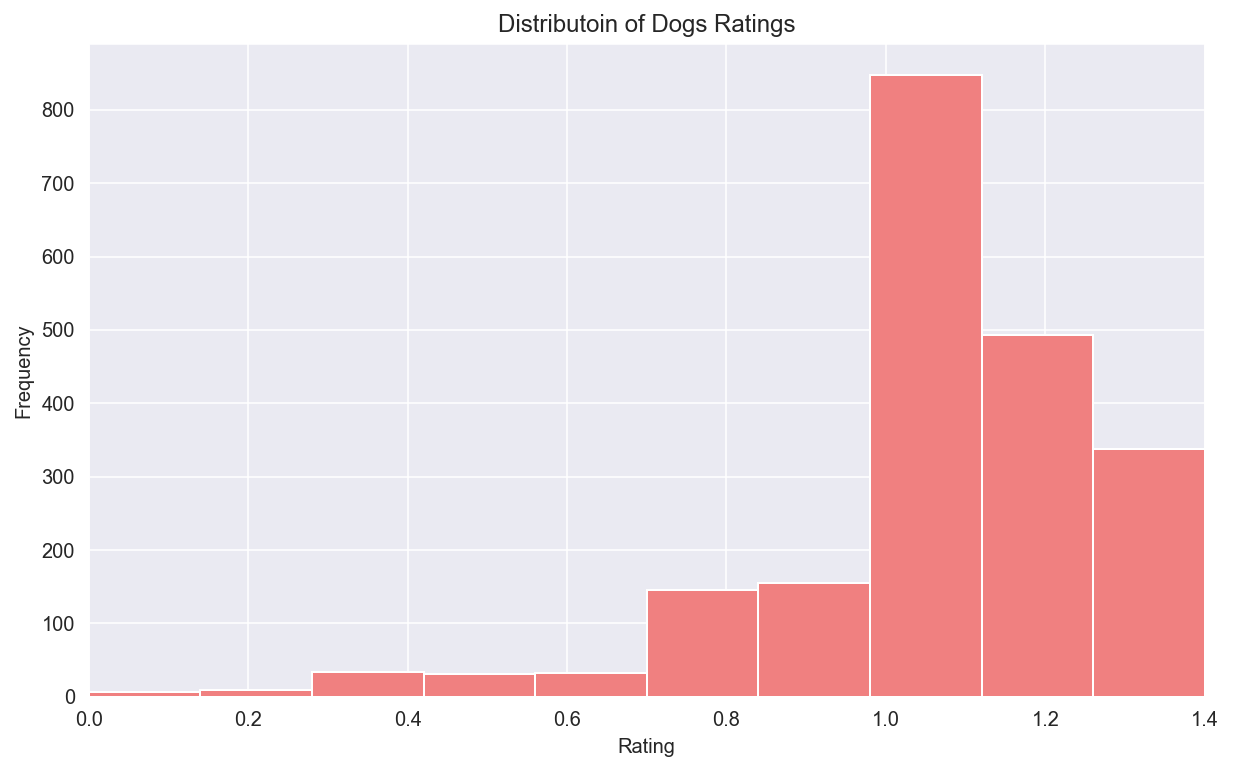

In [116]:
# convert rating proportions column into a numpy array
ratings = np.array(df_archive_clean['rating_proportion'])
# get the maximum and minimum rating proportions
min_rating , max_rating = df_archive_clean['rating_proportion'].min(),df_archive_clean['rating_proportion'].max()

# set the plot size
plt.figure(figsize = (10,6))
# set the x axis limits
plt.xlim(min_rating , max_rating)
# create the histogram
plt.hist(ratings , color = "lightcoral")
# set the plot title and labels
plt.title('Distributoin of Dogs Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency');

From the above histogram, we can find that in general, more than 50 percent of the tweets received ratings with numerators greater than the denominators. This could give us a clue that the majority of dogs are getting high ratings by this account.

### Insight (2): Distribution of Ratings based on Dog Stage

Before diving deeper in concluding which dog stage is getting the higher ratings, let us understand how the tweets counts are distributed among these stages.

In [126]:
# get the number of records with extracted dog stage with respect to the total number of tweets 
df_archive_clean[['tweet_id' , 'dog_stage']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2089 entries, 0 to 2355
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   tweet_id   2089 non-null   int64   
 1   dog_stage  336 non-null    category
dtypes: category(1), int64(1)
memory usage: 34.9 KB


In [117]:
# get the number of records for each dog stage
dog_stage_count = df_archive_clean.groupby('dog_stage').count()['tweet_id']
dog_stage_count

dog_stage
doggo      84 
floofer    9  
pupper     220
puppo      23 
Name: tweet_id, dtype: int64

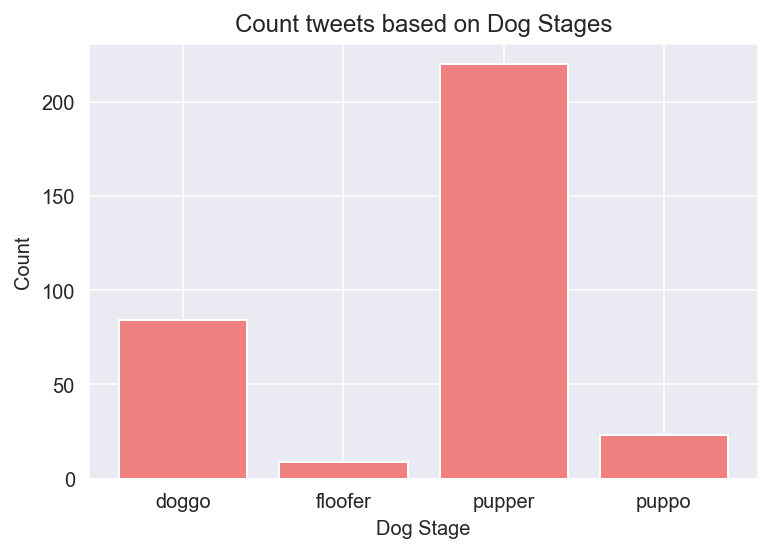

In [118]:
# the x locations for the bars
ind = np.arange(len(dog_stage_count))

# create the plot bars
plt.bar(ind, dog_stage_count, color='lightcoral')

# set the plot title and labels
plt.xlabel('Dog Stage')
plt.ylabel('Count')
plt.title('Count tweets based on Dog Stages')

#set the xtickes    
plt.xticks(ind, dog_stage_count.index); 

From the bar chart, we can find that dogs in 'pupper' stage are the ones securing the majority of these tweet counts in which more than 200 tweets, taking into consideration that there are only 336 records in the dataset out of 2089 which has extracted dog stage.

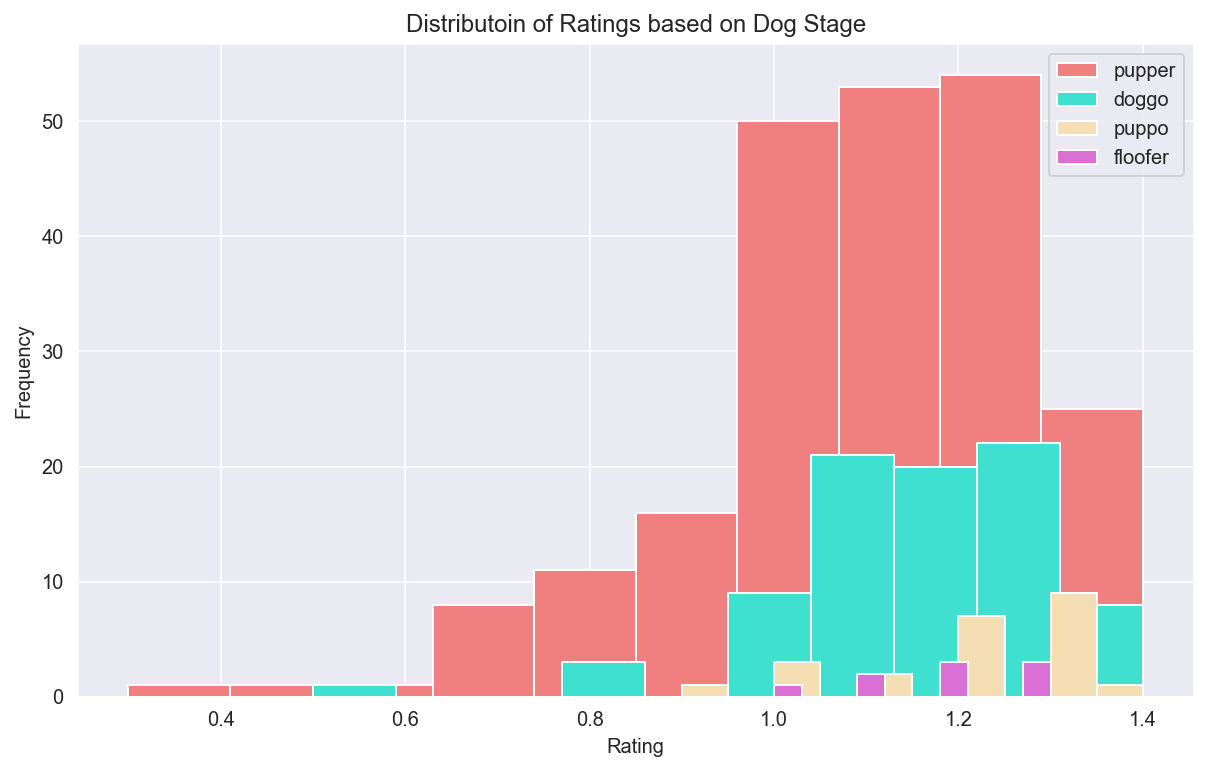

In [119]:
# create new dataframes based on each dog stage and convert rating proportions columns into a numpy arrays
pupper_ratings = np.array(df_archive_clean.query('dog_stage == "pupper"')['rating_proportion'])
doggo_ratings = np.array(df_archive_clean.query('dog_stage == "doggo"')['rating_proportion'])
puppo_ratings = np.array(df_archive_clean.query('dog_stage == "puppo"')['rating_proportion'])
floofer_ratings = np.array(df_archive_clean.query('dog_stage == "floofer"')['rating_proportion'])

# set the plot size
plt.figure(figsize = (10,6))

# create the histograms
plt.hist(pupper_ratings , color = "lightcoral" ,label='pupper')
plt.hist(doggo_ratings , color = "turquoise" ,label='doggo')
plt.hist(puppo_ratings , color = "wheat" ,label='puppo')
plt.hist(floofer_ratings , color = "orchid" ,label='floofer')

# set the plot title and labels
plt.title('Distributoin of Ratings based on Dog Stage')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# set the legend
plt.legend();

As the above bar chart shows, it is clear that the majority of tweets for each dog stage is getting ratings higher than 10 (or we can say ratings with numerators greater than the denominators as some ratings are out of scales different than 10). Which leads us to the conclusion that receiving a high dog rating is not biased by the dog stage.

### Insight (3): The Relation between Dog Ratings and Favorites & Retweets Count 

In [120]:
# get the non-null count for the retweet and favorite in comparision to the total number of records
df_archive_clean[['tweet_id' , 'retweet_count' , 'favorite_count' , 'rating_proportion']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2089 entries, 0 to 2355
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet_id           2089 non-null   int64  
 1   retweet_count      2082 non-null   Int64  
 2   favorite_count     2082 non-null   Int64  
 3   rating_proportion  2089 non-null   float64
dtypes: Int64(2), float64(1), int64(1)
memory usage: 85.7 KB


Since 7 records have missing values for the retweet and favorite count columns, I am goining to create a new dataframe without these records.

In [121]:
# create a new dataframe without the records that have missing retweet and favorite count
df_plot = df_archive_clean[df_archive_clean['favorite_count'].notna()]\
                            [['tweet_id' , 'retweet_count' , 'favorite_count' , 'rating_proportion']]
df_plot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2082 entries, 0 to 2355
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweet_id           2082 non-null   int64  
 1   retweet_count      2082 non-null   Int64  
 2   favorite_count     2082 non-null   Int64  
 3   rating_proportion  2082 non-null   float64
dtypes: Int64(2), float64(1), int64(1)
memory usage: 85.4 KB


In [122]:
# get the mean favorite count for each rating value
favorite_avg = df_plot.groupby('rating_proportion')['favorite_count'].mean()
favorite_avg

rating_proportion
0.000    12549.000000
0.100    6432.500000 
0.200    2009.333333 
0.300    2134.473684 
0.400    2522.357143 
0.500    2391.516129 
0.600    2434.625000 
0.700    2752.820000 
0.800    2155.854167 
0.900    2185.701299 
0.975    18351.000000
1.000    3844.440000 
1.100    6258.389549 
1.126    1685.000000 
1.127    6560.000000 
1.200    10053.658487
1.300    20277.136986
1.350    42499.000000
1.400    25867.000000
Name: favorite_count, dtype: float64

In [123]:
# get the mean retweet count for each rating value
retweet_avg = df_plot.groupby('rating_proportion')['retweet_count'].mean()
retweet_avg

rating_proportion
0.000    1634.500000
0.100    2709.000000
0.200    1153.666667
0.300    818.578947 
0.400    974.500000 
0.500    929.580645 
0.600    898.250000 
0.700    931.700000 
0.800    761.666667 
0.900    711.357143 
0.975    6153.000000
1.000    1356.428235
1.100    1955.437055
1.126    476.000000 
1.127    1612.000000
1.200    2722.934560
1.300    6007.523973
1.350    8879.000000
1.400    7801.400000
Name: retweet_count, dtype: float64

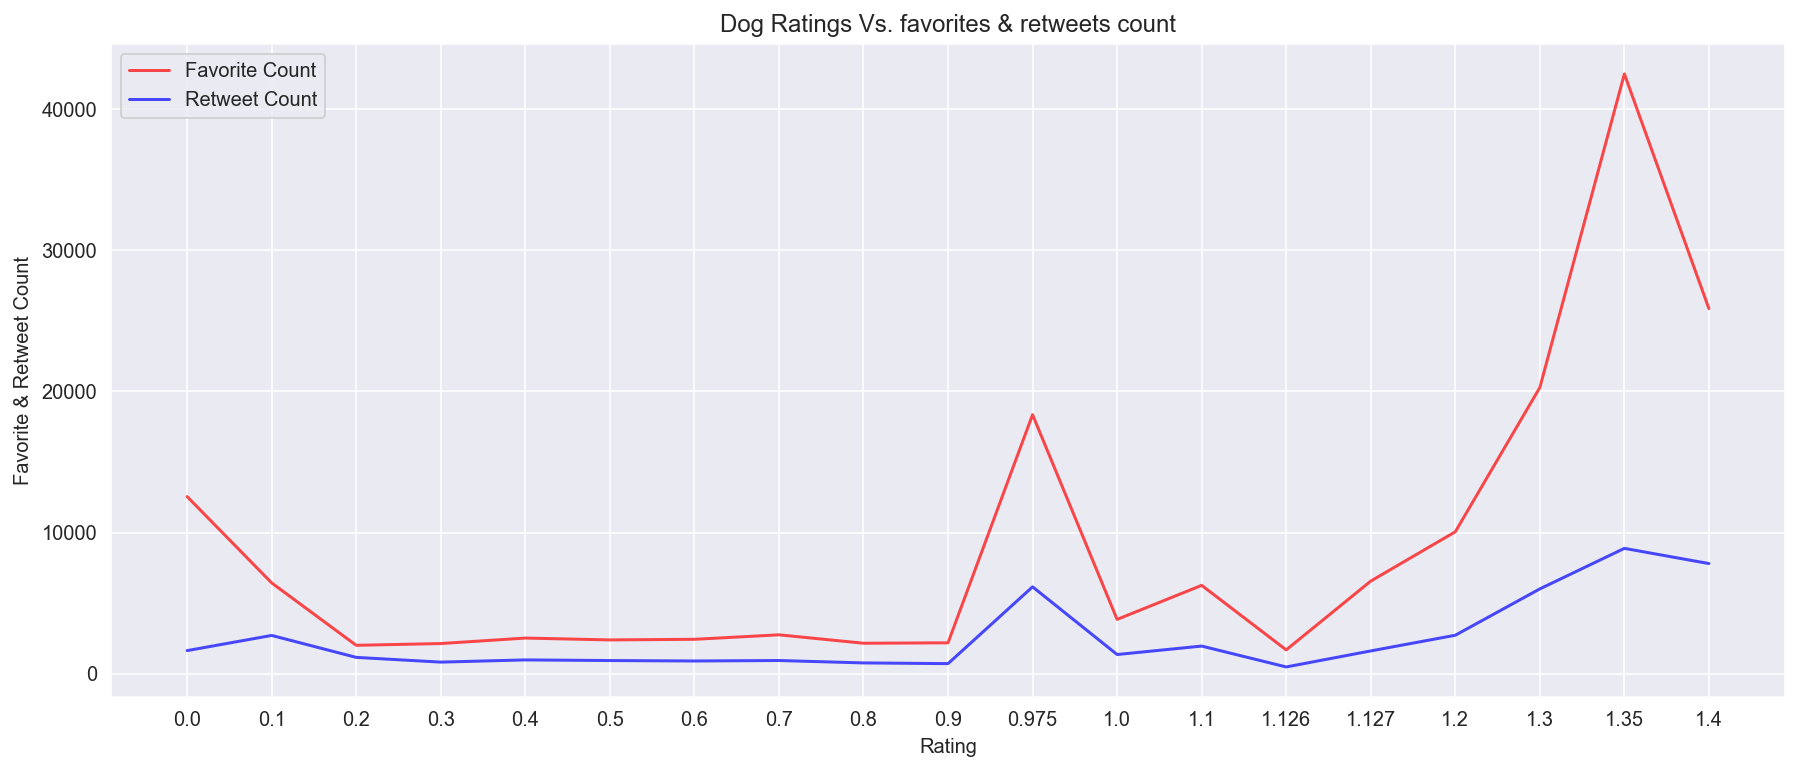

In [129]:
# the x locations
ind = np.arange(len(favorite_avg))  

# set the plot size
plt.figure(figsize = (15,6))

# create the plot
plt.plot(ind, favorite_avg, color='r' , alpha = 0.7, label = 'Favorite Count')
plt.plot(ind, retweet_avg, color='b' , alpha = 0.7, label = 'Retweet Count')

# set the plot title and labels
plt.ylabel('Favorite & Retweet Count')
plt.xlabel('Rating')
plt.title('Dog Ratings Vs. favorites & retweets count')
 
# set the xtickes    
plt.xticks(ind, favorite_avg.index)

# set the legend
plt.legend();

From the line chart, we can find that there is a relationship the dog ratings and retweets counts as tweets which received higher ratings are more likely to retweeted by other twitter users, but this relationship is not that significant compared to than one that favorite have with the dog ratings. It is obvious that a rating received from WeRateDogs is strongly affecting the number of likes a dog tweet could have as higher ratings triggers extremely higher favorite count.  

<a id='ref'></a>
## References

1. https://stackoverflow.com/questions/21058935/python-json-loads-shows-valueerror-extra-data
2. https://stackoverflow.com/questions/25351968/how-to-display-full-non-truncated-dataframe-information-in-html-when-convertin
3. https://www.geeksforgeeks.org/python-pandas-series-str-startswith/
4. https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id
5. https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/
6. https://stackoverflow.com/questions/7370801/how-to-measure-elapsed-time-in-python
7. https://stackoverflow.com/questions/22591174/pandas-multiple-conditions-while-indexing-data-frame-unexpected-behavior
8. https://stackoverflow.com/questions/13851535/delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression-involving
9. https://stackoverflow.com/questions/40698043/slicing-multiple-ranges-of-columns-in-pandas-by-list-of-names
10. https://www.geeksforgeeks.org/python-pandas-split-strings-into-two-list-columns-using-str-split/
11. https://stackoverflow.com/questions/7911504/python-string-operation-extract-text-between-html-tags
12. https://stackoverflow.com/questions/23549231/check-if-a-value-exists-in-pandas-dataframe-index
13. https://stackoverflow.com/questions/56064849/pandas-string-extract-all-the-matches
14. https://stackoverflow.com/questions/19155718/select-pandas-rows-based-on-list-index
15. https://stackoverflow.com/questions/15325182/how-to-filter-rows-in-pandas-by-regex
16. https://stackoverflow.com/questions/28986489/how-to-replace-text-in-a-column-of-a-pandas-dataframe
17. https://kanoki.org/2019/03/23/pandas-rename-and-reorder-columns/
18. https://stackoverflow.com/questions/3777861/setting-y-axis-limit-in-matplotlib
19. https://stackoverflow.com/questions/9012008/pythons-re-return-true-if-string-contains-regex-pattern